### <span style="color:purple; font-weight:bold;">Candidate Name: Anirban Bose</span>
<h3><strong style="color:purple;">Assignment Name:</strong> <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques" target="_blank">House Prices: Advanced Regression Techniques (Kaggle)</a></h3>
<h3><strong style="color:purple;">Task: Exploratory Data Analysis(EDA) and Feature Engineering</strong></h3>


#### **I. Import the packages**

In [119]:
# Import the relevant packages. Kindly ensure that modules for these packages are already installed before using them (use pip install <module name>).

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import json

In [120]:
# This package ensures the dataframes are displayed in scrollable manner

from IPython.display import display, HTML

#### **II. Define the functions**

In [121]:
# Function to create scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

In [122]:
# Function to convert datatypes of specific columns
def convert_columns_to_dypes(df, columns, datatype):
    
    # Validate input columns
    invalid_columns = [col for col in columns if col not in df.columns]
    if invalid_columns:
        raise ValueError(f"The following columns are not in the DataFrame: {invalid_columns}")

    # Convert datatypes of specified columns 
    df = df.copy()
    for col in columns:
        df[col] = df[col].astype(datatype)
    
    return df

In [123]:
# Function to check the null values
def check_null_values(df):
    
    # Calculate null counts and missing percentages
    null_values_df = df.isnull().sum().reset_index(name='Null_Counts').rename(columns={'index': 'Column'})
    null_values_df['Missing_Percentage'] = (null_values_df['Null_Counts'] / len(df)) * 100

    # Filter rows with non-zero null counts and sort by missing percentage
    filtered_null_values_df = null_values_df[null_values_df['Null_Counts'] != 0].sort_values(by='Missing_Percentage', ascending=False)

    return filtered_null_values_df

In [124]:
# Function to plot the histogram
def plot_histogram_with_normal_overlay(data, column, bins=50, color='purple'):
    
    # Calculate the mean and standard deviation of the column
    mu = data[column].mean()
    sigma = data[column].std()

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data[column], bins=bins, density=True, color=color, alpha=0.75, label="Histogram")

    # Calculate the normal distribution
    x_norm = np.linspace(data[column].min(), data[column].max(), 100)
    y_norm = stats.norm.pdf(x_norm, mu, sigma)

    # Overlay the normal distribution
    plt.plot(x_norm, y_norm, color='green', label=f'Normal dist. (μ={mu:.2f}, σ={sigma:.2f})')

    # Add titles and labels
    plt.title(f'Histogram with Normal Distribution Overlay for {column}')
    plt.xlabel(column)
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    plt.show()



In [125]:
# Function to create a boxplot
def plot_boxplot_for_outliers(data, column, figsize=(10, 6), color='orange'):
    
    plt.figure(figsize=figsize)
    sns.boxplot(x=data[column], color=color)
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()

In [126]:
# Function to create a Q-Q plot
def plot_qq(data, column):
    
    # Generate Q-Q plot data
    qq_data = stats.probplot(data[column], dist="norm")

    # Extract the theoretical quantiles and ordered values
    theoretical_quantiles = qq_data[0][0]
    ordered_values = qq_data[0][1]

    # Calculate the line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(theoretical_quantiles, ordered_values)
    line_x = theoretical_quantiles
    line_y = intercept + slope * line_x

    # Create the Q-Q plot
    plt.figure(figsize=(10, 6))
    plt.scatter(theoretical_quantiles, ordered_values, color='purple', alpha=0.7, label='Ordered Values')
    plt.plot(line_x, line_y, color='green', label=f'Best Fit Line (slope={slope:.2f})')
    plt.title(f'Q-Q Plot for {column}')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Ordered Values')
    plt.legend()
    plt.grid(True)
    plt.show()



In [127]:
# Function for log transformations of columns
def log_transform_column(df, column):
    
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")

    # Ensure no zero or negative values to avoid math domain errors
    if (df[column] <= 0).any():
        raise ValueError(f"Column '{column}' contains zero or negative values, which cannot be log-transformed.")

    # Create a new column for the log-transformed values
    df = df.copy()
    df[f'Log_{column}'] = np.log(df[column])

    return df

In [128]:
# Function for feature engineering
def custom_features(df):
    df_out = df.copy()
    df_out['PropertyAge'] = df_out['YrSold'] - df_out['YearBuilt']
    df_out['PropertyAge'] = df_out['PropertyAge'].astype(int)
    df_out['TotalSF'] = df_out['TotalBsmtSF'] + df_out['1stFlrSF'] + df_out['2ndFlrSF']
    df_out['TotalBath'] = df_out['FullBath'] + 0.5 * df_out['HalfBath'] + df_out['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df_out['HasRemodeled'] = (df_out['YearRemodAdd'] != df_out['YearBuilt']).astype(bool)
    df_out['Has2ndFloor'] = (df_out['2ndFlrSF'] > 0).astype(bool)
    df_out['HasGarage'] = (df_out['GarageArea'] > 0).astype(bool)

    # Define columns to convert to categorical
    numerical_to_categorical_columns = [
                            'MSSubClass', 'Street', 'Alley', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold'
                        ]

    # convert them to categorical
    df_out = convert_columns_to_dypes(df_out, numerical_to_categorical_columns, 'object' )
    
    return df_out

In [129]:
#Function for one hot encoding
def category_onehot_multcols(df, multcolumns):
    
    return pd.get_dummies(df, columns=multcolumns)

#### **III. Exploratory Data Analysis (EDA) and Data PreProcessing**

In [130]:
# Get base directory. 
base_dir = os.path.dirname(os.getcwd())
print("Base directory:", base_dir)

Base directory: c:\Users\4553620\OneDrive - Northwestern University\Self_Projects\Data_Science_Projects\Housing Prices_Kaggle


In [131]:
# Create input directory
input_dir = os.path.join(base_dir, "input")
print("Input directory:", input_dir)

Input directory: c:\Users\4553620\OneDrive - Northwestern University\Self_Projects\Data_Science_Projects\Housing Prices_Kaggle\input


In [132]:
# Import the data. 

df_train  = pd.read_csv(os.path.join(input_dir,"train.csv"))
df_test = pd.read_csv(os.path.join(input_dir,"test.csv"))

In [133]:
# Get the number of rows and columns of the train and test data

print(f"\nTrain Data (Rows, Columns): {df_train.shape}")
print(f"\nTest Data (Rows, Columns): {df_test.shape}")


Train Data (Rows, Columns): (1460, 81)

Test Data (Rows, Columns): (1459, 80)


<strong><u>Insights:</u></strong>

The missing column in the test dataset is the *SalePrice*, which is the independent variable.

##### <span style="color:blue; font-weight:bold;">Get dataset info</span>

In [134]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<strong><u>Insights:</u></strong>

Some columns have fewer than 1460 non-null entries, which means they have missing values:

LotFrontage, Alley, MasVnrType, MasVnrArea, BsmtQual, Electrical, FireplaceQu, GarageYrBlt, etc.

Some have a lot of missing data:
-   Alley: only 91 non-null out of 1460
-   PoolQC: only 7 non-null
-   MiscFeature: only 54 non-null

We may need to:
-   Drop these columns if they aren't useful
-   Impute missing values (fill with mean, median, mode, or predictive techniques)

##### <span style="color:blue; font-weight:bold;">Get initial data types</span>

In [135]:
# Get the initial datatypes of the columns and display

display(HTML(create_scrollable_table(pd.DataFrame({
                                        'Column': df_train.columns,
                                        'Datatype': df_train.dtypes.values
                                                }), 
                                     'data_types', 
                                     'Initial Data Types for Train.csv Data')))

,Column,Datatype
0,Id,int64
1,MSSubClass,int64
2,MSZoning,object
3,LotFrontage,float64
4,LotArea,int64
5,Street,object
6,Alley,object
7,LotShape,object
8,LandContour,object
9,Utilities,object


##### <span style="color:blue; font-weight:bold;">Summary Statistics</span>

In [136]:
# For visual analysis, we can transpose the summary statistics of numerical columns to show the show the summary statistics for each numerical column
df_numerical_columns = df_train.select_dtypes(include = [np.number]) # to gather the numerical columns
numerical_summary_stats = df_numerical_columns.describe().T 
display(HTML(create_scrollable_table(numerical_summary_stats, 
                                     'numerical_summary_stats', 
                                     'Numerical Summary Statistics for Train.csv Data'))) 

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [137]:
# Similarly, get the summary statistics for categorical columns

df_categorical_columns = df_train.select_dtypes(include = [object]) # to gather the categorical columns
categorical_summary_stats = df_categorical_columns.describe().T 
display(HTML(create_scrollable_table(categorical_summary_stats, 
                                     'categorical_summary_stats', 
                                     'Categorical Summary Statistics for Train.csv Data'))) 

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


##### <span style="color:blue; font-weight:bold;">Understanding marginal distribution of dependent variable - SalePrice</span>

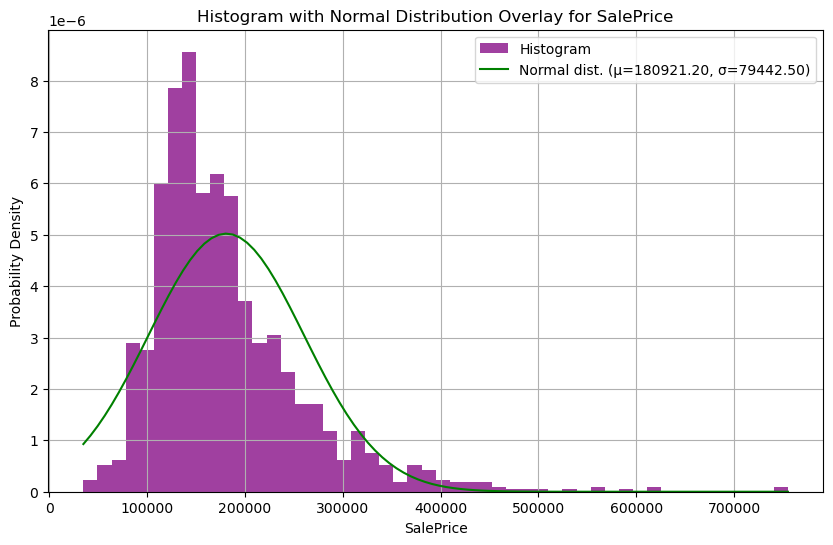

In [138]:
# Plot histogram for the 'SalePrice' column

plot_histogram_with_normal_overlay(df_train, 'SalePrice')

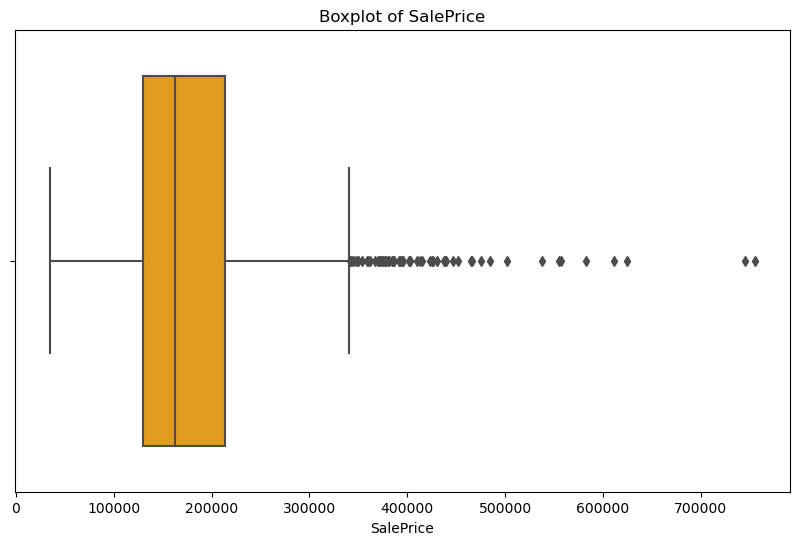

In [139]:
# Identify outliers in SalePrice using a boxplot
plot_boxplot_for_outliers(df_train, 'SalePrice')

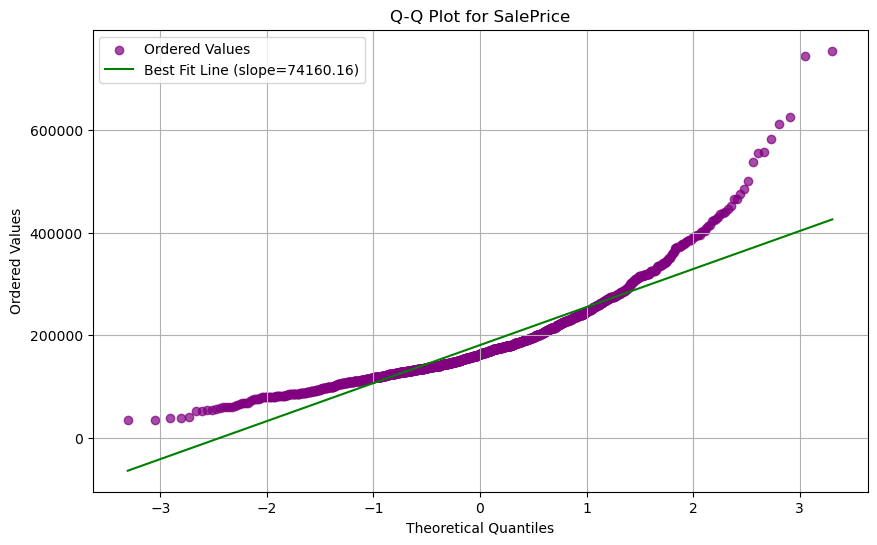

In [140]:
# Plot Q-Q plot for the 'SalePrice' column

plot_qq(df_train, 'SalePrice')

<strong><u>Insights:</u></strong>

*Theoretical Quantiles vs. Ordered Values:* 

Observation: In SalePrice, significant deviations from the line occur at the tails, suggesting non-normality at the extreme ends of the dataset.


*Residuals:*

Observation:

At lower quantiles (negative theoretical quantiles), residuals are high, showing that actual values are larger than expected.

*Key Insights:*

Skewness: The distribution likely exhibits positive skewness, as the upper tail (higher ordered values) deviates more significantly from the theoretical line.

Outliers: Extreme residuals suggest the presence of outliers, particularly on the high-value end of the dataset.

Non-Normality: The dataset does not strictly follow a normal distribution. This non-normality may impact statistical models that assume normality.

*Recommendations:*

This analysis underscores the importance of scaling and potential log transformations to normalize the dependent variable for modeling. 

##### <span style="color:blue; font-weight:bold;">Log transformation of dependent variable - SalePrice</span>

In [141]:
# Create a log column of SalePrice. Remember, if we chose a model in which Log_SalePrice is used, we have to do the same for df_test
df_train = log_transform_column(df_train, 'SalePrice')

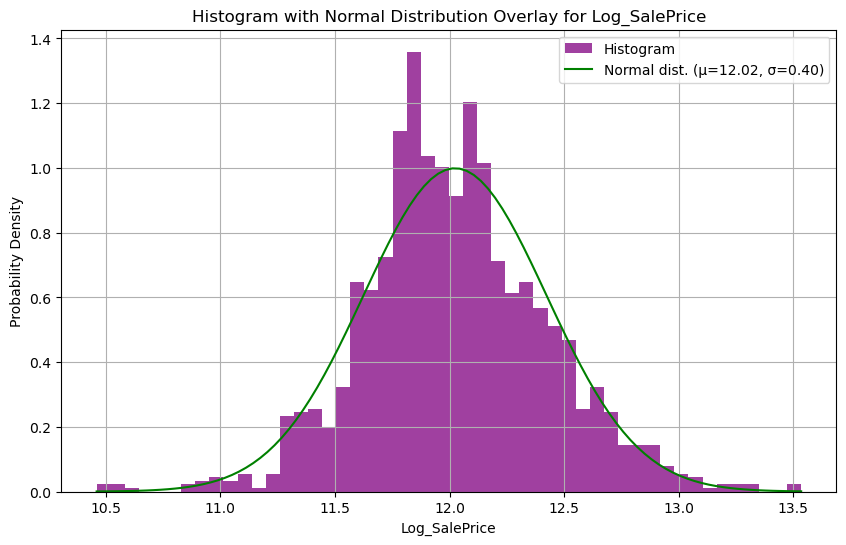

In [142]:
# Now draw the histogram for the log SalePrice column
plot_histogram_with_normal_overlay(df_train, 'Log_SalePrice')

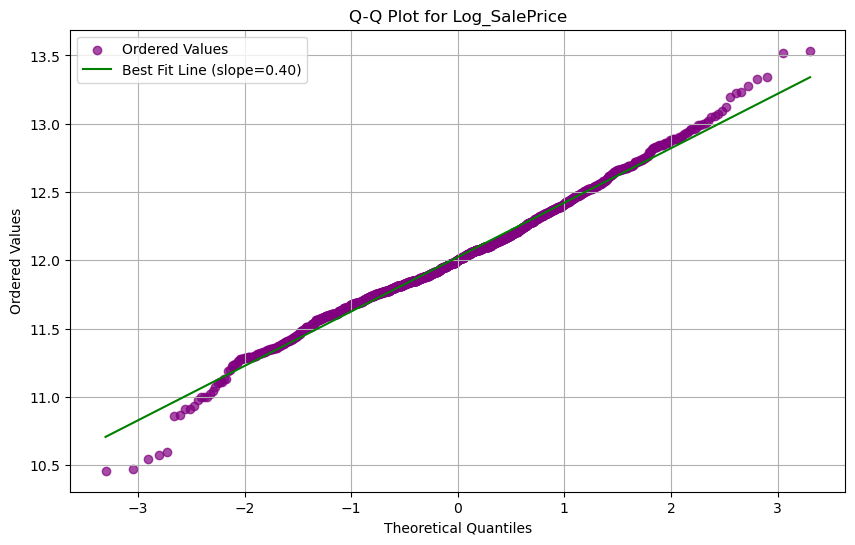

In [143]:
# Now run the Q-Q plot for the log SalePrice column
plot_qq(df_train, 'Log_SalePrice')

<strong><u>Insights:</u></strong>

*Good Fit to Theoretical Distribution:*

Small residuals (close to zero) suggest that the observed data closely follow the theoretical distribution.
For example, for mid-range theoretical quantiles, the residuals are relatively small, indicating alignment.

*Deviations in the Tails:*

Large positive or negative residuals in the extreme quantiles (e.g., very high or low values) indicate deviations from the theoretical distribution.
These deviations could suggest heavier tails, skewness, or outliers in the data.

*Overall Trends:*

The residuals show varying patterns, with higher deviations in extreme quantiles. This could imply that while the data approximately follow the theoretical distribution in the center, the tails deviate significantly.
This behavior is typical when the observed data has more extreme values than the theoretical model predicts (e.g., leptokurtic distributions).

*Recommendations:*
Large residuals in extreme quantiles suggest that the observed data has outliers or a heavier-tailed distribution than the theoretical model. These deviations may need addressing, especially if they influence model performance. 

IQR: Outliers are data points that fall below *Q1 - 1.5 x IQR* or above *Q3 + 1.5 x IQR*.

I am retaining the outliers for now because of the following reasons:
1. In small datasets, removing outliers can significantly reduce the amount of data, potentially hurting the model's performance.
2. Machine learning models like tree-based algorithms (e.g., Random Forest, XGBoost) are robust to outliers. In these cases, removing outliers might not be necessary.
3. In some cases, outliers represent genuine and valuable information (e.g., very high property prices in luxury neighborhoods). Removing them may lead to loss of critical insights.

##### <span style="color:blue; font-weight:bold;">Investigate and manage missing data and outliers</span>

In [144]:
# Let us check for null values in the dataset. Also, add another column showing missing percentage.

filtered_null_values_df = check_null_values(df_train)

display(HTML(create_scrollable_table(filtered_null_values_df, 
                                     'null_values', 
                                     'Null/Missing values in dataset')))

,Column,Null_Counts,Missing_Percentage
72,PoolQC,1453,99.520548
74,MiscFeature,1406,96.301370
6,Alley,1369,93.767123
73,Fence,1179,80.753425
25,MasVnrType,872,59.726027
57,FireplaceQu,690,47.260274
3,LotFrontage,259,17.739726
58,GarageType,81,5.547945
59,GarageYrBlt,81,5.547945
60,GarageFinish,81,5.547945


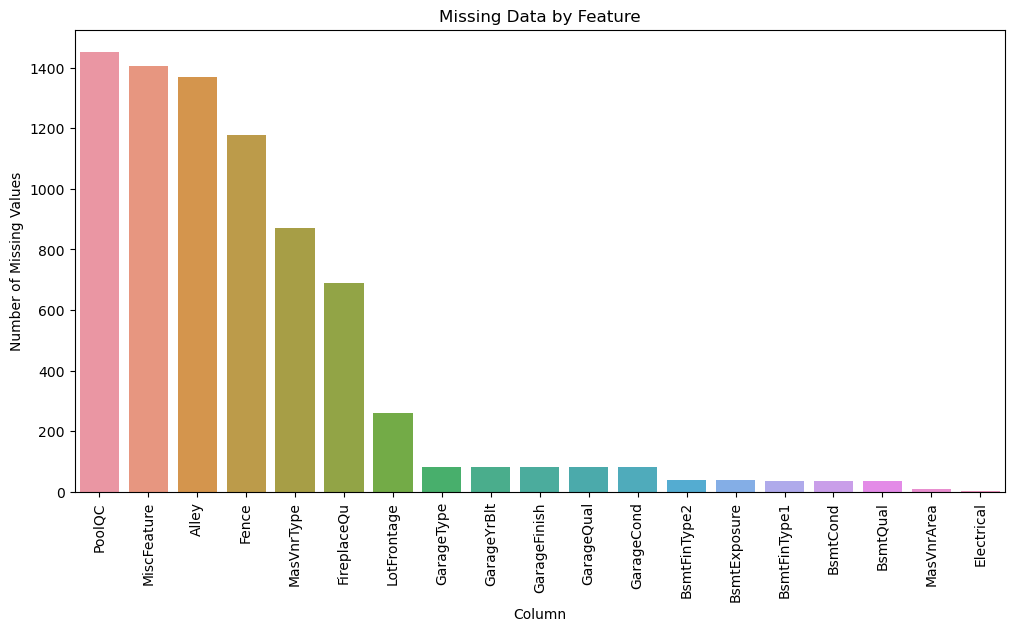

In [145]:
# Visualize missing data
plt.figure(figsize=(12, 6))
sns.barplot(x=filtered_null_values_df.Column, y=filtered_null_values_df.Null_Counts,)
plt.title('Missing Data by Feature')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=90)
plt.show()

<strong><u>Insights:</u></strong>

**Following transformations are to be done for missing data**

*Categorical Features:*

-   For features like Alley, PoolQC, Fence, MiscFeature: Replace missing values with "NA" (indicating "No Access" or "Not Available") to retain meaningful data without losing records.
-   For features with low missing values (e.g., MasVnrType, Electrical), impute with the mode (most frequent category).

*Numerical Features:*

-   Features like LotFrontage (259 missing values) could be imputed based on neighborhood median values because properties in the same area often have similar frontage.
-   Features like GarageYrBlt can be imputed as 0 or a placeholder for "No Garage."
-   For continuous numerical features with minimal missing values, use the median as it's less sensitive to outliers.

*Basement Features:*

-   Features like BsmtQual, BsmtCond, etc., have "NA" for properties without a basement. Retain "NA" or impute missing values consistently across basement-related features.

In [146]:
# Function to handle missing data
def handle_missing_data(df):
    
    # Handle categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col in ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'BsmtQual', 'BsmtCond', 
                   'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                   'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
            df[col] = df[col].fillna("NA")  # Meaningful "No" or "Not Available"
        else:
            df[col] = df[col].fillna(df[col].mode()[0])  # Impute with mode

    # Handle numerical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_cols:
        if col in ['LotFrontage']:
            # Impute LotFrontage based on neighborhood mean
            df[col] = df.groupby('Neighborhood')[col].transform(lambda x: x.fillna(x.mean()))
        elif col in ['MasVnrArea']:
            # Impute masonry veneer area with 0 for missing
            df[col] = df[col].fillna(0)
        else:
            # General case: Impute numerical columns with median
            df[col] = df[col].fillna(df[col].median())
    
    return df

In [147]:
# Handle the missing data using the function

df_train = handle_missing_data(df_train)

In [148]:
# Exploring rows with missing values after the transformation

rows_with_missing_values = df_train[df_train.isnull().any(axis=1)]
print(f"No. of rows with missing values: {len(rows_with_missing_values)}")

No. of rows with missing values: 0


##### <span style="color:blue; font-weight:bold;">Let us draw a correlation matrix for correlation of all numerical features with SalePrice. This would help us identify the numerical features with most correlation.</span>

In [149]:
# Re-extract the numerical features and get the summary statistics

df_numerical_columns = df_train.select_dtypes(include = [np.number]) # to gather the numerical columns
numerical_summary_stats = df_numerical_columns.describe().T # to get the summary statistics

display(HTML(create_scrollable_table(numerical_summary_stats, 
                                     'numerical_summary_stats', 
                                     'Numerical Summary Statistics for Train.csv Data'))) 

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.000000,365.750000,730.500000,1095.250000,1460.000000
MSSubClass,1460.0,56.897260,42.300571,20.000000,20.000000,50.000000,70.000000,190.000000
LotFrontage,1460.0,70.725218,22.426978,21.000000,60.000000,70.083333,80.000000,313.000000
LotArea,1460.0,10516.828082,9981.264932,1300.000000,7553.500000,9478.500000,11601.500000,215245.000000
OverallQual,1460.0,6.099315,1.382997,1.000000,5.000000,6.000000,7.000000,10.000000
OverallCond,1460.0,5.575342,1.112799,1.000000,5.000000,5.000000,6.000000,9.000000
YearBuilt,1460.0,1971.267808,30.202904,1872.000000,1954.000000,1973.000000,2000.000000,2010.000000
YearRemodAdd,1460.0,1984.865753,20.645407,1950.000000,1967.000000,1994.000000,2004.000000,2010.000000
MasVnrArea,1460.0,103.117123,180.731373,0.000000,0.000000,0.000000,164.250000,1600.000000
BsmtFinSF1,1460.0,443.639726,456.098091,0.000000,0.000000,383.500000,712.250000,5644.000000


In [150]:
# Perform the correlation for both SalePrice and Log_SalePrice
df_saleprice_correlation = df_numerical_columns.corr()['SalePrice'].sort_values(ascending=False).reset_index().rename(columns={'index': 'Feature', 'SalePrice': 'Correlation'})

display(HTML(create_scrollable_table(df_saleprice_correlation, 
                                     'correlation_dataframe', 
                                     'Correlation Information - SalePrice')))


df_logsaleprice_correlation = df_numerical_columns.corr()['Log_SalePrice'].sort_values(ascending=False).reset_index().rename(columns={'index': 'Feature', 'SalePrice': 'Correlation'})

display(HTML(create_scrollable_table(df_logsaleprice_correlation, 
                                     'log_correlation_dataframe', 
                                     'Correlation Information - Log_SalePrice')))

,Feature,Correlation
0,SalePrice,1.000000
1,Log_SalePrice,0.948374
2,OverallQual,0.790982
3,GrLivArea,0.708624
4,GarageCars,0.640409
5,GarageArea,0.623431
6,TotalBsmtSF,0.613581
7,1stFlrSF,0.605852
8,FullBath,0.560664
9,TotRmsAbvGrd,0.533723


,Feature,Log_SalePrice
0,Log_SalePrice,1.000000
1,SalePrice,0.948374
2,OverallQual,0.817184
3,GrLivArea,0.700927
4,GarageCars,0.680625
5,GarageArea,0.650888
6,TotalBsmtSF,0.612134
7,1stFlrSF,0.596981
8,FullBath,0.594771
9,YearBuilt,0.586570


<strong><u>Insights:</u></strong>

The correlation values indicate the linear relationship between features and SalePrice/Log_SalePrice. 

-   **Key contributors** include GrLivArea, GarageCars, GarageArea, and TotalBsmtSF, which strongly influence property value. 
-   **Moderate correlations** are observed for features like FullBath, TotRmsAbvGrd, and MasVnrArea, while **weaker correlations**, such as LotFrontage and WoodDeckSF, have less impact. 
-   **Negligible or negative correlations**, like KitchenAbvGr and EnclosedPorch, suggest minimal or slightly negative effects. 

*We should focus on strongly correlated features for predictive modeling, while weaker ones may require careful evaluation or removal.*

##### <span style="color:blue; font-weight:bold;">Investigate correlation between certain potential predictors of the dependent variable (SalePrice / log_SalePrice)</span>

<span style="color:green; font-weight:bold;">a. What is the distribution of dwelling types, and how do they relate to sale prices?</span>

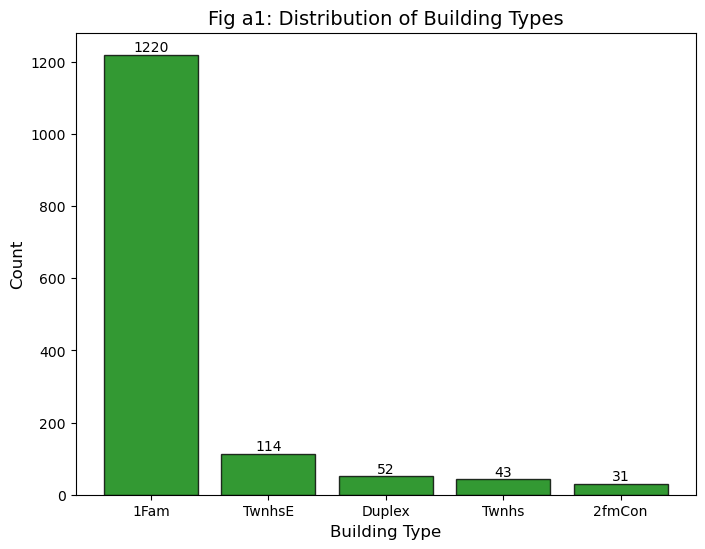

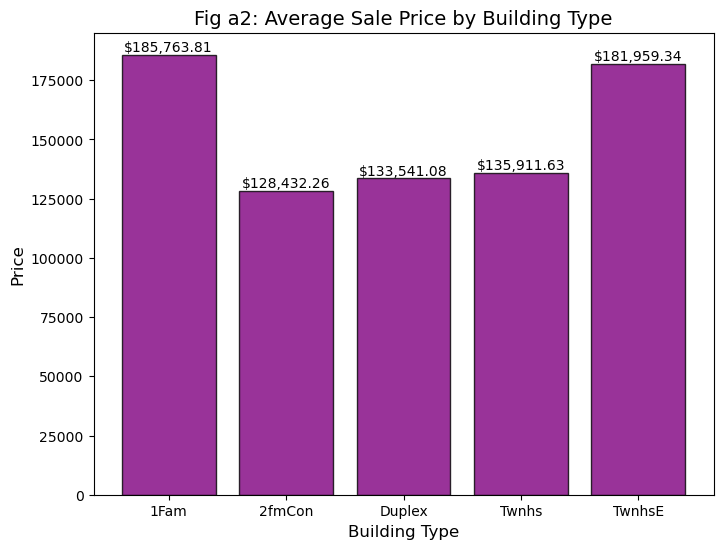

In [151]:
# Data preparation
dwelling_types = df_train['BldgType'].value_counts()
dwelling_prices = df_train.groupby('BldgType')['SalePrice'].mean()

# Create the first figure: Distribution of Building Types
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.bar(dwelling_types.index, dwelling_types.values, color='green', edgecolor='black', alpha=0.8)
ax1.set_title('Fig a1: Distribution of Building Types', fontsize=14)
ax1.set_xlabel('Building Type', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticks(range(len(dwelling_types.index)))
ax1.set_xticklabels(dwelling_types.index, fontsize=10)
ax1.bar_label(ax1.containers[0], label_type='edge', fontsize=10)

# Create the second figure: Average Sale Price by Building Type
fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.bar(dwelling_prices.index, dwelling_prices.values, color='purple', edgecolor='black', alpha=0.8)
ax2.set_title('Fig a2: Average Sale Price by Building Type', fontsize=14)
ax2.set_xlabel('Building Type', fontsize=12)
ax2.set_ylabel('Price', fontsize=12)
ax2.set_xticks(range(len(dwelling_prices.index)))
ax2.set_xticklabels(dwelling_prices.index, fontsize=10)
ax2.bar_label(ax2.containers[0], labels=[f'${v:,.2f}' for v in dwelling_prices.values], label_type='edge', fontsize=10)

# Show the figures
plt.show()

<strong><u>Insights:</u></strong>

**Fig a1:** The Distribution of Building Types reveals that Single-Family Detached homes dominate in frequency, making them the most common type of dwelling. This highlights their significant presence and importance in the dataset.

**Fig a2:** The Average Sale Price by Building Type shows that Single-Family Detached homes not only have the highest frequency distribution but also command higher sale prices, indicating their strong market value. Additionally, Townhouse End Unit homes are priced notably higher compared to regular Townhouses, showcasing a significant price gap between the two, which could be due to differences in design, size, or amenities.

<span style="color:green; font-weight:bold;">b. How does zoning classification influence sale prices?</span>

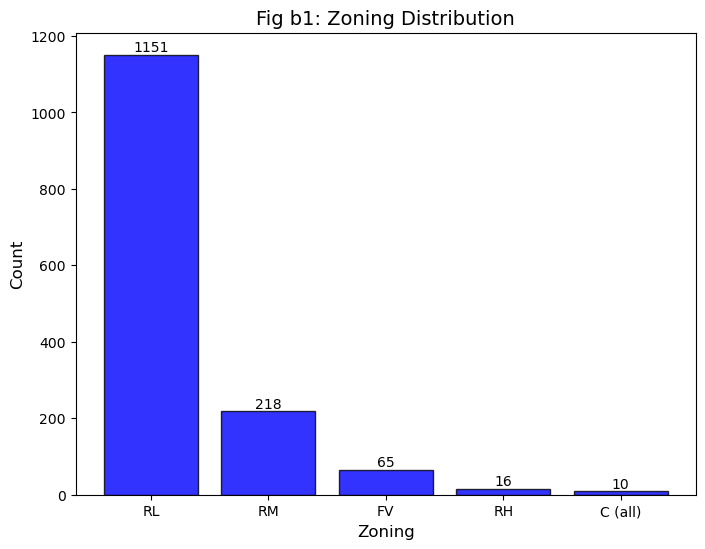

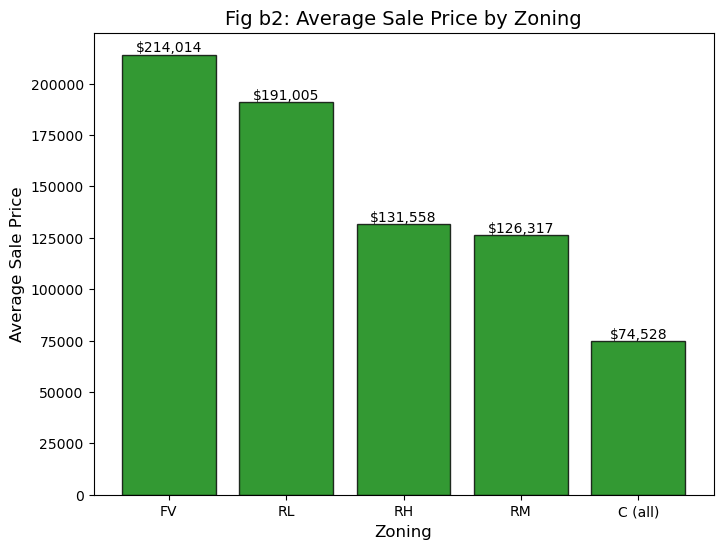

In [152]:
# Data preparation
zoning_prices = df_train.groupby('MSZoning')['SalePrice'].mean().sort_values(ascending=False)
zoning_counts = df_train['MSZoning'].value_counts().sort_values(ascending=False)

# Figure 3: Zoning distribution
fig3, ax3 = plt.subplots(figsize=(8, 6))
bars3 = ax3.bar(zoning_counts.index, zoning_counts.values, color='blue', edgecolor='black', alpha=0.8)
ax3.set_title('Fig b1: Zoning Distribution', fontsize=14)
ax3.set_xlabel('Zoning', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
ax3.bar_label(bars3, fontsize=10)
plt.show()

# Figure 4: Average Sale Price by Zoning
fig4, ax4 = plt.subplots(figsize=(8, 6))
bars4 = ax4.bar(zoning_prices.index, zoning_prices.values, color='green', edgecolor='black', alpha=0.8)
ax4.set_title('Fig b2: Average Sale Price by Zoning', fontsize=14)
ax4.set_xlabel('Zoning', fontsize=12)
ax4.set_ylabel('Average Sale Price', fontsize=12)
ax4.bar_label(bars4, labels=[f'${v:,.0f}' for v in zoning_prices.values], fontsize=10)
plt.show()

<strong><u>Insights:</u></strong>

**Fig b1** and **Fig b2** reveals that residentials in low-density areas command higher demand in the market and also a high average saleprice. Floating Village has low occurence but has highest average price, which might be because of a supply-demand gap.

<span style="color:green; font-weight:bold;">c. Do street and alley access types affect sale prices?</span>

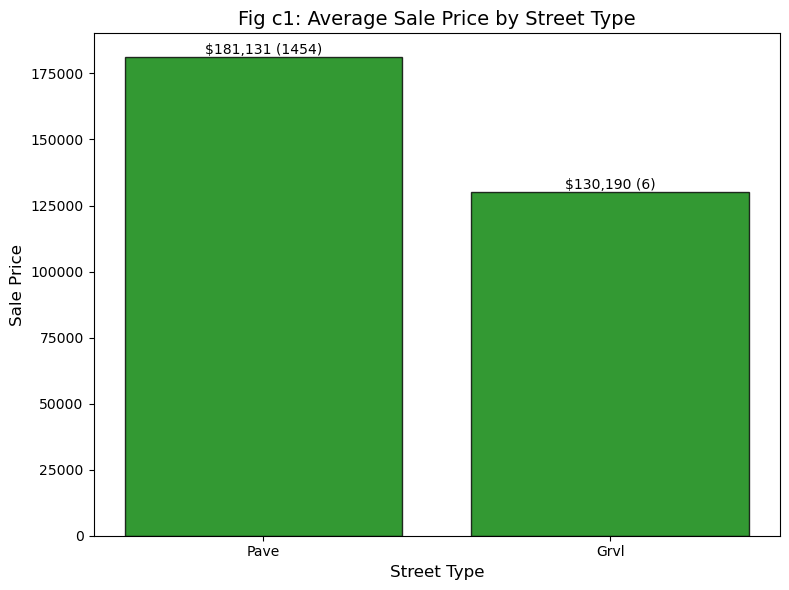

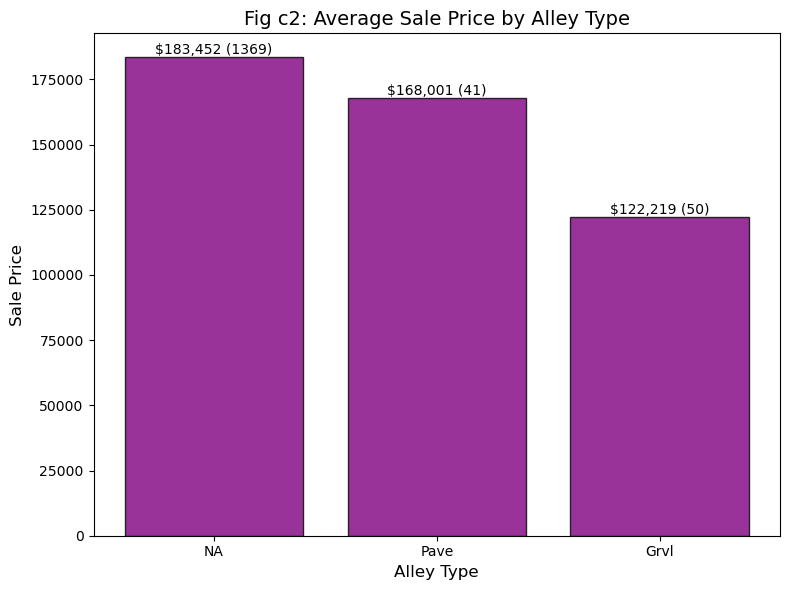

In [153]:
# Calculate average sale prices and frequencies
street_prices = df_train.groupby('Street')['SalePrice'].mean().sort_values(ascending=False)
street_counts = df_train['Street'].value_counts()

alley_prices = df_train.groupby('Alley')['SalePrice'].mean().sort_values(ascending=False)
alley_counts = df_train['Alley'].value_counts()

# Figure for Street Prices
fig5, ax5 = plt.subplots(figsize=(8, 6))
bars_street = ax5.bar(street_prices.index, street_prices.values, color=['green'], edgecolor='black', alpha=0.8)

# Add labels to bars with SalePrice and count
for bar, price, count in zip(bars_street, street_prices.values, street_counts.loc[street_prices.index]):
    ax5.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'${price:,.0f} ({count})',
             ha='center', va='bottom', fontsize=10, color='black')

# Titles and labels
ax5.set_title('Fig c1: Average Sale Price by Street Type', fontsize=14)
ax5.set_xlabel('Street Type', fontsize=12)
ax5.set_ylabel('Sale Price', fontsize=12)

plt.tight_layout()
plt.show()

# Figure for Alley Prices
fig6, ax6 = plt.subplots(figsize=(8, 6))
bars_alley = ax6.bar(alley_prices.index, alley_prices.values, color=['purple'], edgecolor='black', alpha=0.8)

# Add labels to bars with SalePrice and count
for bar, price, count in zip(bars_alley, alley_prices.values, alley_counts.loc[alley_prices.index]):
    ax6.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'${price:,.0f} ({count})',
             ha='center', va='bottom', fontsize=10, color='black')

# Titles and labels
ax6.set_title('Fig c2: Average Sale Price by Alley Type', fontsize=14)
ax6.set_xlabel('Alley Type', fontsize=12)
ax6.set_ylabel('Sale Price', fontsize=12)

plt.tight_layout()
plt.show()


<strong><u>Insights:</u></strong>

**Fig c1:** Average SalePrice by Street Type indicates higher demand for Paved streets. Also paved streets command higher average SalePrice.

**Fig c2:** Average SalePrice by Street Type reveals highest preference for no alleys. Both the frequency and average price for no alleys are the highest.

<span style="color:green; font-weight:bold;">d. What is the average sale price for different property shapes?</span>

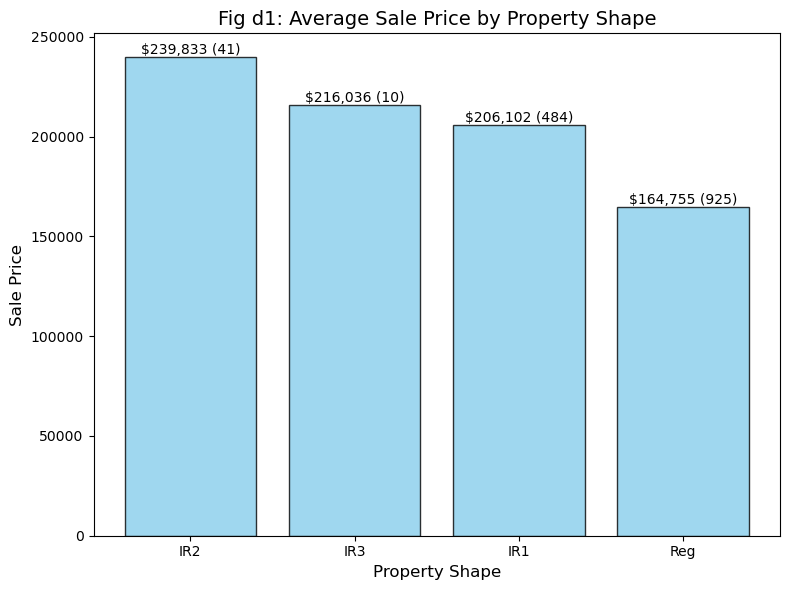

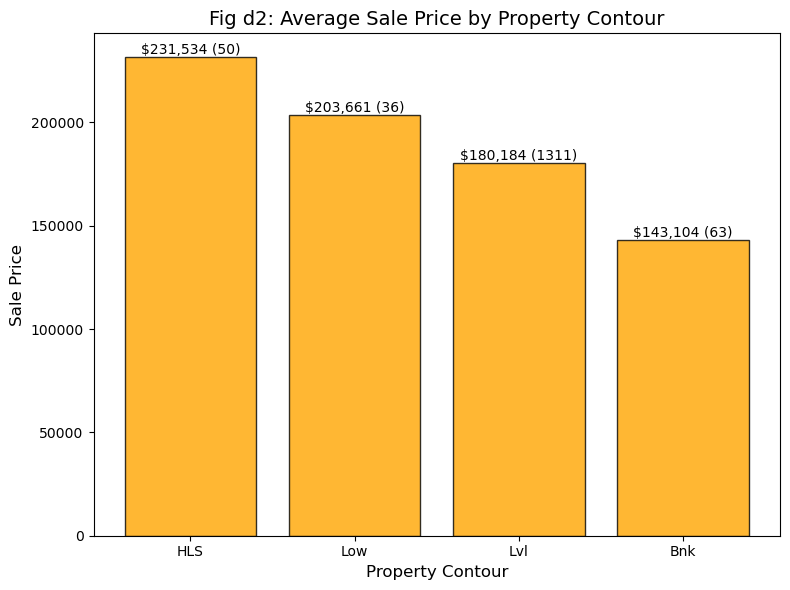

In [154]:
# Average sale price by property shape
shape_prices = df_train.groupby('LotShape')['SalePrice'].mean().sort_values(ascending=False)
shape_counts = df_train['LotShape'].value_counts()

contour_prices = df_train.groupby('LandContour')['SalePrice'].mean().sort_values(ascending=False)
contour_counts = df_train['LandContour'].value_counts()

# Figure for Property Shape Prices
fig7, ax7 = plt.subplots(figsize=(8, 6))
bars_shape = ax7.bar(shape_prices.index, shape_prices.values, color='skyblue', edgecolor='black', alpha=0.8)

# Add labels to bars with SalePrice and count
for bar, price, count in zip(bars_shape, shape_prices.values, shape_counts.loc[shape_prices.index]):
    ax7.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'${price:,.0f} ({count})',
             ha='center', va='bottom', fontsize=10, color='black')

# Titles and labels
ax7.set_title('Fig d1: Average Sale Price by Property Shape', fontsize=14)
ax7.set_xlabel('Property Shape', fontsize=12)
ax7.set_ylabel('Sale Price', fontsize=12)

plt.tight_layout()
plt.show()

# Figure for Property Contour Prices
fig8, ax8 = plt.subplots(figsize=(8, 6))
bars_contour = ax8.bar(contour_prices.index, contour_prices.values, color='orange', edgecolor='black', alpha=0.8)

# Add labels to bars with SalePrice and count
for bar, price, count in zip(bars_contour, contour_prices.values, contour_counts.loc[contour_prices.index]):
    ax8.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'${price:,.0f} ({count})',
             ha='center', va='bottom', fontsize=10, color='black')

# Titles and labels
ax8.set_title('Fig d2: Average Sale Price by Property Contour', fontsize=14)
ax8.set_xlabel('Property Contour', fontsize=12)
ax8.set_ylabel('Sale Price', fontsize=12)

plt.tight_layout()
plt.show()


<strong><u>Insights:</u></strong>

**Fig d1:** This figure shows higher demand for regular shaped properties, but surprisingly moderately regular properties command more average SalePrice. Is there another reason for this consumer behavior?

**Fig d2:** This figure shows hillside properties commanding highest average SalePrice. This is unsurprising since buyers usually prefer highest spots for better view. Interestingly, properties at Near Flat/Level has more demand/availability. 	 

<span style="color:green; font-weight:bold;">e. Is there a correlation between the age of a property and its sale price?</span>

Correlation between Property Age and Sale Price: -0.52


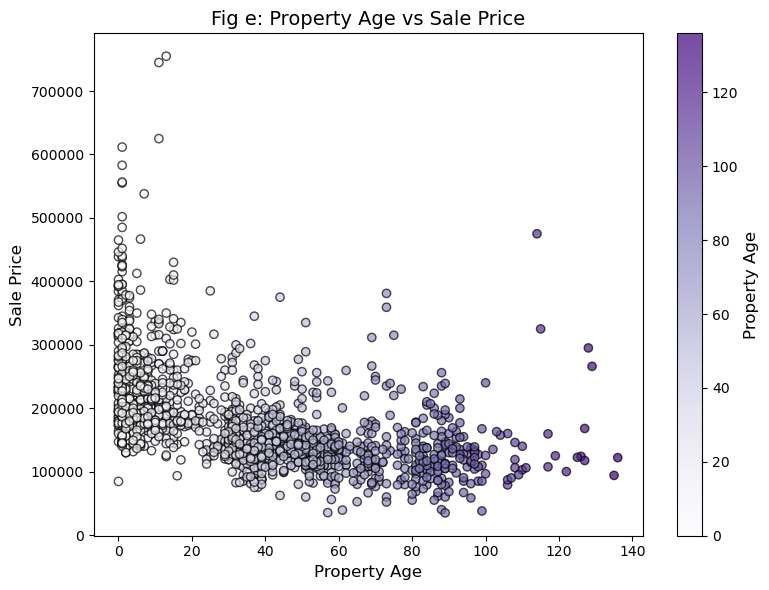

In [155]:
# Calculate Property Age
df_train['PropertyAge'] = df_train['YrSold'] - df_train['YearBuilt']
# Convert PropertyAge to numeric
df_train['PropertyAge'] = pd.to_numeric(df_train['PropertyAge'], errors='coerce')

# Calculate Correlation between Property Age and Sale Price
age_price_corr = df_train['PropertyAge'].corr(df_train['SalePrice'])
print(f'Correlation between Property Age and Sale Price: {age_price_corr:.2f}')

# Create a scatter plot to visualize the relationship between Property Age and Sale Price
fig9, ax9 = plt.subplots(figsize=(8, 6))

scatter = ax9.scatter(df_train['PropertyAge'], df_train['SalePrice'], 
                       c=df_train['PropertyAge'], cmap='Purples', alpha=0.7, edgecolor='k')

# Add a colorbar for Property Age
cbar = fig9.colorbar(scatter, ax=ax9)
cbar.set_label('Property Age', fontsize=12)

# Titles and labels
ax9.set_title('Fig e: Property Age vs Sale Price', fontsize=14)
ax9.set_xlabel('Property Age', fontsize=12)
ax9.set_ylabel('Sale Price', fontsize=12)

# Format y-axis for better readability
ax9.ticklabel_format(axis='y', style='plain')
plt.tight_layout()

# Show the figure
plt.show()


<strong><u>Insights:</u></strong>

**Fig e:** There is generally a downward trend of SalePrice with the Age of the Property. The idea of an antique house seems absent here. 	 

<span style="color:green; font-weight:bold;">f. How does living area size correlate with sale prices?</span>

Correlation between Living Area (above grade) and Sale Price: 0.71


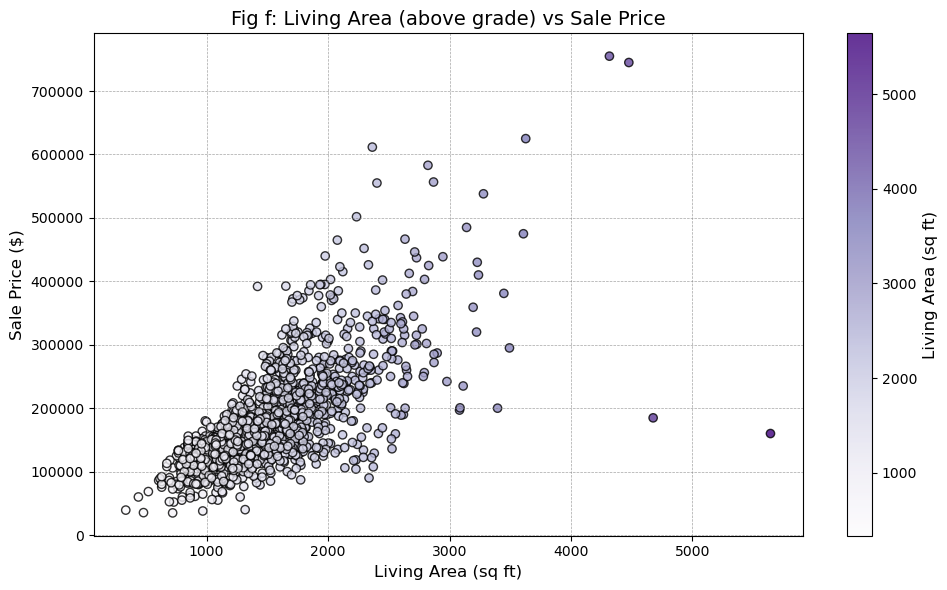

In [156]:
# Calculate Correlation between Living Area and Sale Price
living_area_price_corr = df_train['GrLivArea'].corr(df_train['SalePrice'])
print(f'Correlation between Living Area (above grade) and Sale Price: {living_area_price_corr:.2f}')

# Create a scatter plot
fig10, ax10 = plt.subplots(figsize=(10, 6))
scatter = ax10.scatter(df_train['GrLivArea'], df_train['SalePrice'], 
                        c=df_train['GrLivArea'], cmap='Purples', edgecolor='k', alpha=0.8)

# Add color bar
cbar = plt.colorbar(scatter, ax=ax10)
cbar.set_label('Living Area (sq ft)', fontsize=12)

# Titles and labels
ax10.set_title('Fig f: Living Area (above grade) vs Sale Price', fontsize=14)
ax10.set_xlabel('Living Area (sq ft)', fontsize=12)
ax10.set_ylabel('Sale Price ($)', fontsize=12)

# Add grid for better readability
ax10.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


<strong><u>Insights:</u></strong>

**Fig f:** There is clear upward linear trend of SalePrice with the Living Area. We can also see some datapoints that are outliers- living area > 4000 and sale price < 200000. 

<span style="color:green; font-weight:bold;">g. How does number of garage cars correlate with sale prices?</span>

Correlation between Garage Cars and Sale Price: 0.64


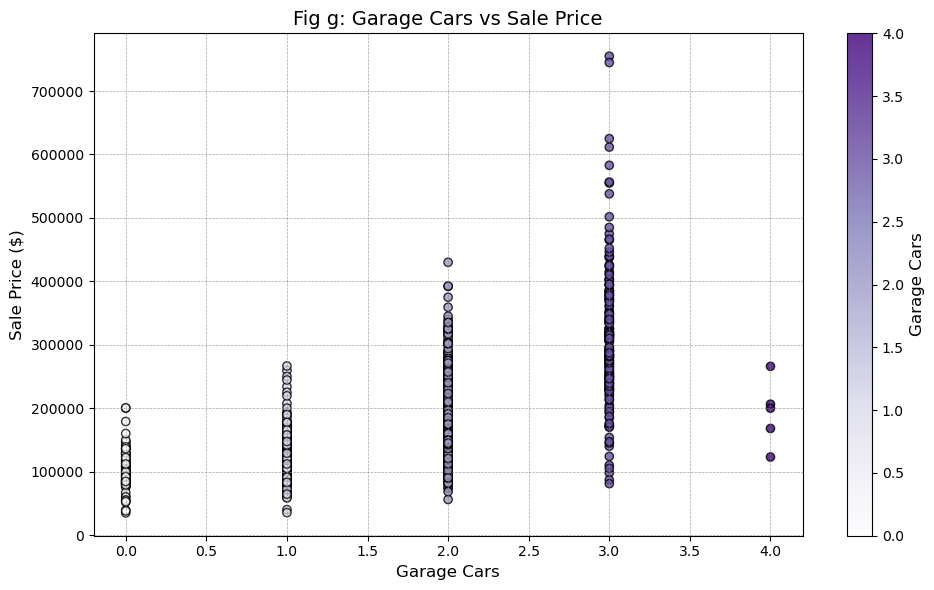

In [157]:
# Calculate Correlation between Living Area and Sale Price
garage_cars_price_corr = df_train['GarageCars'].corr(df_train['SalePrice'])
print(f'Correlation between Garage Cars and Sale Price: {garage_cars_price_corr:.2f}')

# Create a scatter plot
fig11, ax11 = plt.subplots(figsize=(10, 6))
scatter = ax11.scatter(df_train['GarageCars'], df_train['SalePrice'], 
                        c=df_train['GarageCars'], cmap='Purples', edgecolor='k', alpha=0.8)

# Add color bar
cbar = plt.colorbar(scatter, ax=ax11)
cbar.set_label('Garage Cars', fontsize=12)

# Titles and labels
ax11.set_title('Fig g: Garage Cars vs Sale Price', fontsize=14)
ax11.set_xlabel('Garage Cars', fontsize=12)
ax11.set_ylabel('Sale Price ($)', fontsize=12)

# Add grid for better readability
ax11.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


<strong><u>Insights:</u></strong>

**Fig g:** There is an increasing trend with the number of cars in the garage to the SalePrice of the house. 

<span style="color:green; font-weight:bold;">h. How does the Garage Area correlate with sale prices?</span>

Correlation between Garage Area and Sale Price: 0.62


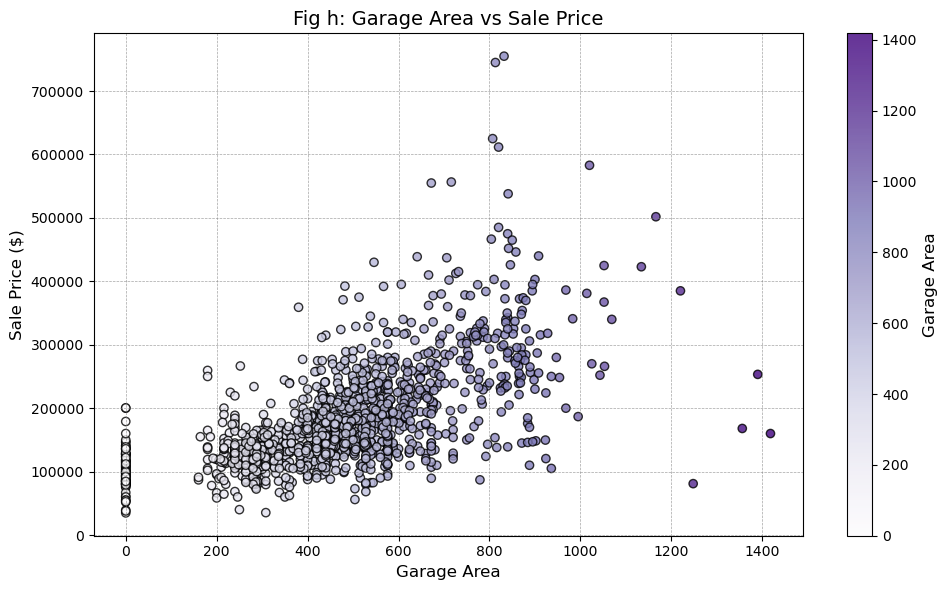

In [158]:
# Calculate Correlation between Garage Area and Sale Price
garage_area_price_corr = df_train['GarageArea'].corr(df_train['SalePrice'])
print(f'Correlation between Garage Area and Sale Price: {garage_area_price_corr:.2f}')

# Create a scatter plot
fig12, ax12 = plt.subplots(figsize=(10, 6))
scatter = ax12.scatter(df_train['GarageArea'], df_train['SalePrice'], 
                        c=df_train['GarageArea'], cmap='Purples', edgecolor='k', alpha=0.8)

# Add color bar
cbar = plt.colorbar(scatter, ax=ax12)
cbar.set_label('Garage Area', fontsize=12)

# Titles and labels
ax12.set_title('Fig h: Garage Area vs Sale Price', fontsize=14)
ax12.set_xlabel('Garage Area', fontsize=12)
ax12.set_ylabel('Sale Price ($)', fontsize=12)

# Add grid for better readability
ax12.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


<strong><u>Insights:</u></strong>

**Fig h:** There is clear upward linear trend of SalePrice with the Garage Area. We can also see some datapoints that are outliers- garage area > 1200 and saleprice < 300000. 

<span style="color:green; font-weight:bold;">i. How does the Total Basement SF correlate with sale prices?</span>

Correlation between Total Basement SF and Sale Price: 0.61


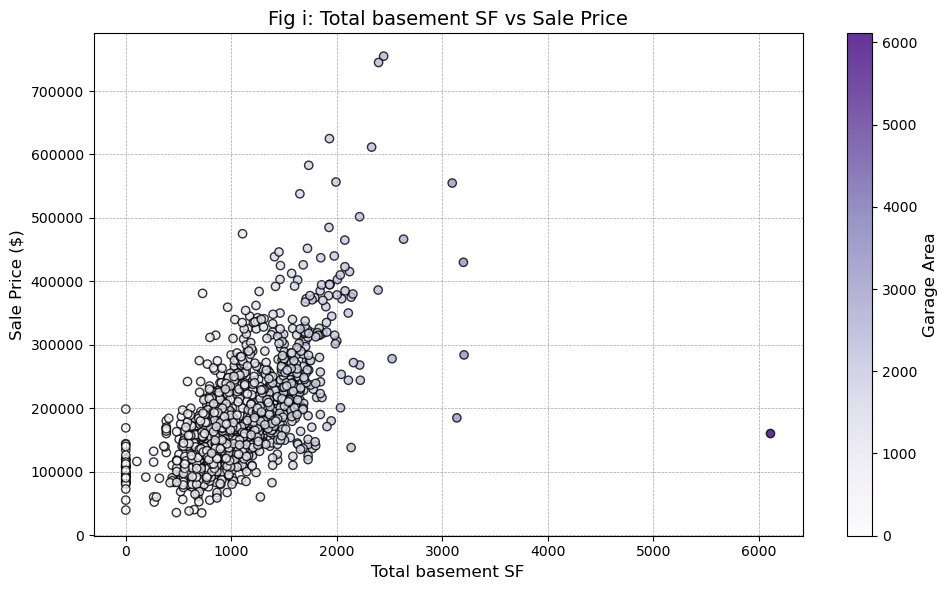

In [159]:
# Calculate Correlation between Total Basement SF and Sale Price
total_bsmtSF_price_corr = df_train['TotalBsmtSF'].corr(df_train['SalePrice'])
print(f'Correlation between Total Basement SF and Sale Price: {total_bsmtSF_price_corr:.2f}')

# Create a scatter plot
fig13, ax13 = plt.subplots(figsize=(10, 6))
scatter = ax13.scatter(df_train['TotalBsmtSF'], df_train['SalePrice'], 
                        c=df_train['TotalBsmtSF'], cmap='Purples', edgecolor='k', alpha=0.8)

# Add color bar
cbar = plt.colorbar(scatter, ax=ax13)
cbar.set_label('Garage Area', fontsize=12)

# Titles and labels
ax13.set_title('Fig i: Total basement SF vs Sale Price', fontsize=14)
ax13.set_xlabel('Total basement SF', fontsize=12)
ax13.set_ylabel('Sale Price ($)', fontsize=12)

# Add grid for better readability
ax13.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


<strong><u>Insights:</u></strong>

**Fig i:** There is clear upward linear trend of SalePrice with the Total basement SF. We can also see some datapoints that are outliers- total basement SF > 6000 and saleprice < 200000. 

##### <span style="color:blue; font-weight:bold;">Handling Outliers</span>


In [160]:
# Dealing with visual outliers

# Condition 1: GrLivArea > 4000 and SalePrice < 200000
cond1 = (df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 200000)

# Condition 2: GarageArea > 1200 and SalePrice < 300000
cond2 = (df_train['GarageArea'] > 1200) & (df_train['SalePrice'] < 300000)

# Condition 3: TotalBsmtSF > 6000 and SalePrice < 200000
cond3 = (df_train['TotalBsmtSF'] > 6000) & (df_train['SalePrice'] < 200000)

# Combine all conditions using OR
outlier_index = df_train[cond1 | cond2 | cond3].index

print(f"The index having outliers are : {outlier_index}")

# Drop the indexes
df_train_after_outlier = df_train.drop(outlier_index,axis=0) 

The index having outliers are : Index([523, 581, 1061, 1190, 1298], dtype='int64')


In [161]:
print(f"\nTrain Data after handling outliers(Rows, Columns): {df_train_after_outlier.shape}")


Train Data after handling outliers(Rows, Columns): (1455, 83)


In [162]:
df_train_after_outlier.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Log_SalePrice,PropertyAge
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,0,2,2008,WD,Normal,208500,12.247694,5
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,0,5,2007,WD,Normal,181500,12.109011,31
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,0,9,2008,WD,Normal,223500,12.317167,7
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,0,2,2006,WD,Abnorml,140000,11.849398,91
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,0,12,2008,WD,Normal,250000,12.429216,8


#### **IV. Feature Engineering**

In [163]:
# Created new features and modify datatypes of existing that we felt we relevant for this model. 
# Kindly refer the function custom_features

df_train_new = custom_features(df_train_after_outlier)
df_train_new.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType,SaleCondition,SalePrice,Log_SalePrice,PropertyAge,TotalSF,TotalBath,HasRemodeled,Has2ndFloor,HasGarage
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,WD,Normal,208500,12.247694,5,2566,3.5,False,True,True
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,WD,Normal,181500,12.109011,31,2524,2.5,False,False,True
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,WD,Normal,223500,12.317167,7,2706,3.5,True,True,True
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,WD,Abnorml,140000,11.849398,91,2473,2.0,True,True,True
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,WD,Normal,250000,12.429216,8,3343,3.5,False,True,True


In [164]:
# Get the updated datatypes of the columns and display

display(HTML(create_scrollable_table(pd.DataFrame({
                                        'Column': df_train_new.columns,
                                        'Datatype': df_train_new.dtypes.values
                                                }), 
                                     'data_types', 
                                     'Updated Data Types for Train.csv Data')))

,Column,Datatype
0,Id,int64
1,MSSubClass,object
2,MSZoning,object
3,LotFrontage,float64
4,LotArea,int64
5,Street,object
6,Alley,object
7,LotShape,object
8,LandContour,object
9,Utilities,object


#### **V. Machine Learning Pre-Processing**

##### <span style="color:blue; font-weight:bold;">One Hot Encoding</span>
Before proceeding further, we have to introduce the concept of one-hot encoding to convert categorical variables into a binary format. This method creates binary columns for each category in the original variable.

In [165]:
# Identify categorical columns in the merged dataset that will be used for one hot encoding. 
# Kindly note that certain columns have been excluded from the list because as per data_description.txt, 
# these categorical columns are either ordinal or has numeric values (therefore not requiring encoding).

columns_for_encoding = df_train_new.select_dtypes(include=['object', 'category']).columns.tolist()
columns_for_encoding = [e for e in columns_for_encoding if e not in ('MSSubClass','YearBuilt', 'YearRemodAdd', 'YrSold', 'OverallQual', 'OverallCond', 'MoSold')]
columns_for_encoding

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [166]:
# Apply one hot encoding

df_train_for_model=category_onehot_multcols(df_train_new, columns_for_encoding)
df_train_for_model.shape

(1455, 405)

In [167]:
# Remove duplicated columns post encoding, if any, from the merged dataset

df_train_for_model = df_train_for_model.loc[:, ~df_train_for_model.columns.duplicated()]
df_train_for_model.shape

(1455, 405)

In [168]:
# Get the datatypes of the columns and display

display(HTML(create_scrollable_table(pd.DataFrame({
                                        'Column': df_train_for_model.columns,
                                        'Datatype': df_train_for_model.dtypes.values
                                                }), 
                                     'data_types', 
                                     'Post-encoding Data Types for Train Data')))

,Column,Datatype
0,Id,int64
1,MSSubClass,object
2,LotFrontage,float64
3,LotArea,int64
4,OverallQual,object
5,OverallCond,object
6,YearBuilt,object
7,YearRemodAdd,object
8,MasVnrArea,float64
9,BsmtFinSF1,int64


##### <span style="color:blue; font-weight:bold;">Save the EDA Output for model consumption</span>

In [169]:
# Create intermediate directory
intermediate_dir = os.path.join(base_dir, "output", "intermediate")
print("Intermediate directory:", intermediate_dir)

Intermediate directory: c:\Users\4553620\OneDrive - Northwestern University\Self_Projects\Data_Science_Projects\Housing Prices_Kaggle\output\intermediate


In [170]:
df_train_for_model.to_csv(
    os.path.join(intermediate_dir, "train_for_model.csv"),
    index=False)

In [171]:
# Extract column names and dtypes as a dictionary
column_types = {
    col: str(dtype) for col, dtype in df_train_for_model.dtypes.items()
}

# Save as JSON
with open(os.path.join(intermediate_dir, "train_for_model_columns_dtypes.json"), "w") as f:
    json.dump(column_types, f, indent=4)